Ersten Schritte der Datenverarbeitung testen

Daten in verteilter Datenstruktur laden

test.csv kann man durch das data_efl_heuer Notebook generieren lassen!

In [1]:
# pyspark hat nach der Installation Probleme und wird nicht automatisch von Python zum importieren gefunden
# dafür gibt es dann extra das findspark tool
import findspark
findspark.init()
from pyspark.sql import SparkSession

datadir = '../data/raw/*.csv'

spark = SparkSession.builder.appName('placegroups').getOrCreate()
dataFrame = spark.read.option('header',True).csv(datadir)

:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/vscode/.ivy2/cache
The jars for the packages stored in: /home/vscode/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cf85289d-ed46-4ff4-bc4d-3399070961ef;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 239ms :: artifacts dl 13ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------------------

Kann man die Daten jetzt per Nutzer aggregieren?

In [2]:
dataFrame.printSchema
dataFrame.show(5)

+--------------------+--------------------+-----------+----------+
|           timestamp|             user_id|pixel_color|coordinate|
+--------------------+--------------------+-----------+----------+
|2022-04-04 04:38:...|vKtmwRQwAYtw5poO4...|    #FF3881|  804,1992|
|2022-04-04 04:38:...|eoZO4uYgBzVoDR0Rb...|    #FFFFFF|  1667,616|
|2022-04-04 04:38:...|Mdd6j8t/24pCeslV3...|    #D4D7D9|   392,467|
|2022-04-04 04:38:...|xHWcOdv98PR7yQNKD...|    #000000|   21,1691|
|2022-04-04 04:38:...|hI0Z36Jzkw+coR+im...|    #515252|  971,1026|
+--------------------+--------------------+-----------+----------+
only showing top 5 rows



In [3]:
from pyspark.sql.functions import col, asc, desc

grouped = dataFrame.groupBy('user_id')
active = grouped.count().orderBy(col('count').desc())
active.show(5)

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|AxBTmhBMbr1sbDw/2...|   20|
|VmiTfdqG3P1MlZokx...|   15|
|X8gpDfO6+Z87SKKTy...|   15|
|FjHp8Fg+uuheibUWk...|   15|
|DIECtVqoJqBlL6A0C...|   15|
+--------------------+-----+
only showing top 5 rows



```
+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|AxBTmhBMbr1sbDw/2...|   20|
|FjHp8Fg+uuheibUWk...|   15|
|X8gpDfO6+Z87SKKTy...|   15|
|VmiTfdqG3P1MlZokx...|   15|
|DIECtVqoJqBlL6A0C...|   15|
+--------------------+-----+
only showing top 5 rows
```

Wir versuchen mal die Daten für den aktivsten Nutzer zu aggregieren

In [4]:
mostactive = active.first()
mostactiveid = mostactive.asDict()['user_id']
topFrame = dataFrame.filter("user_id == '"+mostactiveid+"'")

topFrame.show(5)

+--------------------+--------------------+-----------+----------+
|           timestamp|             user_id|pixel_color|coordinate|
+--------------------+--------------------+-----------+----------+
|2022-04-04 04:41:...|AxBTmhBMbr1sbDw/2...|    #FFA800|    1447,5|
|2022-04-04 04:46:...|AxBTmhBMbr1sbDw/2...|    #FFFFFF|   1636,21|
|2022-04-04 04:51:...|AxBTmhBMbr1sbDw/2...|    #3690EA|    1287,8|
|2022-04-04 04:51:...|AxBTmhBMbr1sbDw/2...|    #BE0039|   1926,19|
|2022-04-04 04:56:...|AxBTmhBMbr1sbDw/2...|    #2450A4|   1310,10|
+--------------------+--------------------+-----------+----------+
only showing top 5 rows



In [5]:
from datetime import datetime
import time

onetime = '2022-04-04 04:38:15.038 UTC'

def stamp2time(stamp):
    d =  datetime.strptime(stamp,"%Y-%m-%d %H:%M:%S.%f UTC")
    return int(time.mktime(d.timetuple()))

print(stamp2time(onetime))

1649047095


In [6]:
xs = [int(val.coordinate.split(',')[0]) for val in topFrame.select('coordinate').collect()]
ys = [int(val.coordinate.split(',')[1]) for val in topFrame.select('coordinate').collect()]
ts = [stamp2time(val.timestamp) for val in topFrame.select('timestamp').collect()]

Zeitstempel sind Sekunden die seit 1970 vergangen sind. Interessant sind aber nur Sekunden seit Beginn des Experiments.

In [7]:
mints = min(ts)
ts = [(t - mints) for t in ts]

In [8]:

print(xs)
print(ys)
print(ts)

[1447, 1636, 1287, 1926, 1310, 1617, 655, 612, 1575, 658, 1403, 777, 1741, 1299, 586, 788, 656, 1611, 584, 1765]
[5, 21, 8, 19, 10, 16, 1896, 1917, 7, 14, 2, 8, 10, 20, 1931, 11, 1884, 33, 26, 8]
[0, 308, 617, 617, 925, 1233, 1542, 1542, 1542, 1851, 2160, 2160, 2160, 2469, 2469, 2777, 2777, 3085, 3393, 3393]


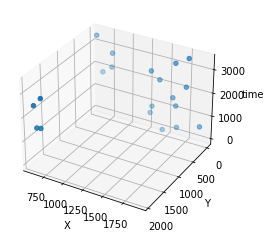

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs,ys,ts)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('time')
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

Machen wir das ganze mal für 3 Nutzer ...

In [10]:
userids = [val['user_id'] for val in active.take(3)]

In [11]:
topFrame = dataFrame.filter(dataFrame.user_id.isin(userids))

userpixel = []
for userid in userids:
    xs = [int(val.coordinate.split(',')[0]) for val in topFrame.select('coordinate').filter(topFrame.user_id == userid).collect()]
    ys = [int(val.coordinate.split(',')[1]) for val in topFrame.select('coordinate').filter(topFrame.user_id == userid).collect()]
    ts = [stamp2time(val.timestamp) for val in topFrame.select('timestamp').filter(topFrame.user_id == userid).collect()]
    mints = min(ts)
    ts = [(t - mints) for t in ts]
    userpixel.append([xs,ys,ts])

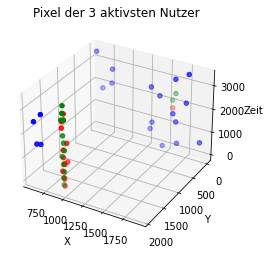

In [15]:
import itertools
# eigentlich cheaten: die Funktion hab ich viel später als dieses Notebook geschrieben
# aber so wird das Bild irgendwo gespeichert :)
from src.visualization.visuialization_functions import show_and_save

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors=itertools.cycle(["blue","green","red"])
for pixellist in userpixel:
    xs,ys,ts = list(pixellist)
    ax.scatter(xs,ys,ts,color=next(colors))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Pixel der 3 aktivsten Nutzer')
ax.set_zlabel('Zeit')
ax.set_ylim(ax.get_ylim()[::-1])
show_and_save(ax)
    